Check out https://chih-ling-hsu.github.io/2017/08/30/NN-XOR

Import libraries

In [1]:
import numpy
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

#from mlxtend.plotting import plot_decision_regions
#from pylib.plot import plot_decision_boundary

# The following code is used for hiding the warnings and make this notebook clearer.
import warnings
warnings.filterwarnings('ignore')

Define the available activation function

In [2]:
def tanh(x):
    return (1.0 - numpy.exp(-2*x))/(1.0 + numpy.exp(-2*x))

def tanh_derivative(x):
    return (1 + tanh(x))*(1 - tanh(x))


In [3]:
def sigmoid(x):
    return 1 / (1 + numpy.exp(-x))

def sigmoid_derivative(y):
    return y * (1 - y)


Define the neural network

In [4]:
class NeuralNetwork:
    
    ##########
    ## comments will concern a net with arch_net=[2,4,1]
    
    
    
    #########
    # parameters
    # ----------
    # self:      the class object itself
    # net_arch:  consists of a list of integers, indicating
    #            the number of neurons in each layer, i.e. the network architecture
    #########
    def __init__(self, net_arch, act='sigmoid'):
        
        # make results repeatable
        numpy.random.seed(0)

        # select the activaation function.
        if act == 'sigmoid':
            self.activity = sigmoid
            self.activity_derivative = sigmoid_derivative
        elif act == 'tanh':
            self.activity = tanh
            self.activity_derivative = tanh_derivative
        
        # define other params.
        self.layers = len(net_arch)
        self.steps_per_epoch = 1
        self.arch = net_arch
        
        # Initialize the weights, making sure we also 
        # initialize the weights for the biases that we will add later
        # Random initialization with range of weight values (-1,1)
        self.weights = []
        for layer in range(self.layers - 1):
            w = 2*numpy.random.rand(net_arch[layer] + 1, net_arch[layer+1]) - 1
            self.weights.append(w) # weights = [3x4, 5x1]
            
    
    def _forward_prop(self, x):
        
        # first layer
        y = x # [1x3] 

        # hidden layer
        for i in range(len(self.weights)-1):
            activation = numpy.dot(y[i], self.weights[i]) # 1x3 dot 3x4 -> 1x4 
            activity = self.activity(activation) # 1x4 
            # add the bias for the next layer
            activity = numpy.concatenate((numpy.ones(1), numpy.array(activity))) # 1x5
            y.append(activity) # [1x3, 1x5] 

        # last layer - no need to concatenate (no need to add bias unit)
        activation = numpy.dot(y[-1], self.weights[-1]) # 1x5 dot 5x1 -> 1x1
        activity = self.activity(activation) # 1x1 
        y.append(activity) # [1x3, 1x5, 1x1] 
        
        return y # [1x3, 1x5, 1x1]
    
    def _back_prop(self, y, target, learning_rate):
        
        # last weight matrix
        error = target - y[-1] # 1x1
        delta_vec = [error * self.activity_derivative(y[-1])] # 1x1 * 1x1 = 1x1

        # we need to begin from the back, from the next to last layer
        # first weigth matrix: 1x1 dot 1x4 * 1x4 = 1x4 
        for i in range(self.layers-2, 0, -1):
            error = delta_vec[-1].dot(self.weights[i][1:].T) 
            error = error*self.activity_derivative(y[i][1:])
            delta_vec.append(error) # [1x1, 1x4]

        # Now we need to set the values from back to front
        delta_vec.reverse() # [1x4, 1x1]
        
        # Finally, we adjust the weights, using the backpropagation rules
        for i in range(len(self.weights)):
            layer = y[i].reshape(1, self.arch[i]+1) # 1x3, 1x5
            delta = delta_vec[i].reshape(1, self.arch[i+1]) # 1x4, 1x1
            self.weights[i] += learning_rate*layer.T.dot(delta) # 3x1 dot 1x4 = 3x4, 5x1 dot 1x1 = 5x1
    
    #########
    # parameters
    # ----------
    # self:    the class object itself
    # data:    the set of all possible pairs of booleans True or False indicated by the integers 1 or 0
    # labels:  the result of the logical operation 'xor' on each of those input pairs
    #########
    def fit(self, data, labels, learning_rate=0.1, epochs=100):
        
        # Add bias units to the input layer - 
        # add a "1" to the input data (the always-on bias neuron)
        ones = numpy.ones((1, data.shape[0])) # 1x4
        Z = numpy.concatenate((ones.T, data), axis=1) # 2x4 -> 3x4
        
        # keep track of prediction error in the plot prediction error, epochs) 
        er = []
        
        for k in range(epochs):
            if k % 1000 == 0:
                print('epochs: {}'.format(k))
                
            #if k % 1000 == 0:
                #plot_decision_regions(data, labels, nn)
                #plt.xlabel('x-axis')
                #plt.ylabel('y-axis')
                #plt.legend(loc='upper left')
                #plt.tight_layout()
                #plt.show()
        
            # Sampling only one element. That is, we use online learning i.e.
            # in each epoch we train the net on a single, arbitrarily chosen
            # input.
            # Notice in the final plot, how slowly the net converges. 
            # Better would be to use batching...
            sample = numpy.random.randint(data.shape[0]) 
            
            # We will now go ahead and set up our feed-forward propagation:
            x = [Z[sample]]
            y = self._forward_prop(x)

            # Now we do our back-propagation of the error to adjust the weights:
            target = labels[sample]
            self._back_prop(y, target, learning_rate)
            
            # keep track of the error for the plot 
            err = 0
            for i in range(len(nn.predict(X))):
                err += numpy.square(self.predict(data)[i] - labels[i])
            er.append(err)
        
        # plot prediction error vs epoch
        x_axis = [i for i in range(epochs)]
        y_axis = [er[j] for j in range(epochs)]
        fig, ax = plt.subplots()
        ax.plot(x_axis, y_axis)
        ax.set(xlabel='epoch', 
               ylabel='prediction error', 
               title='prediction error vs epoch')
        plt.show()
    
    #########
    # the predict function is used to check the prediction result of
    # this neural network.
    # 
    # parameters
    # ----------
    # self:   the class object itself
    # x:      single input data
    #########
    def predict_single_data(self, x):
        
        val = numpy.concatenate((numpy.ones(1).T, numpy.array(x))) # 1x3
        
        for i in range(0, len(self.weights)):
            val = self.activity(numpy.dot(val, self.weights[i])) # 1x3 dot 3x4 = 1x4, 1x5 dot 5x1=1x1
            val = numpy.concatenate((numpy.ones(1).T, numpy.array(val))) # 1x5, 1x2
        return val[1] # val is concat'd  because of the last step, and we want the element that was already
                      # there. concat adds the element in the 1st position, so we call the second position.
    
    #########
    # the predict function is used to check the prediction result of
    # this neural network.
    # 
    # parameters
    # ----------
    # self:   the class object itself
    # X:      the input data array
    #########
    def predict(self, X):
        
        Y = numpy.array([]).reshape(0, self.arch[-1])
        for x in X:
            y = numpy.array([[self.predict_single_data(x)]])
            Y = numpy.vstack((Y,y))
        return Y
        

In [5]:
numpy.random.seed(0)

# Initialize the NeuralNetwork with
# 2 input neurons
# 4 hidden neurons
# 1 output neuron
nn = NeuralNetwork([2,4,1])

# Set the input data
X = numpy.array([[0, 0], 
                 [0, 1],
                 [1, 0], 
                 [1, 1]])

# Set the labels, the correct results for the xor operation
y = numpy.array([0,
                 1, 
                 1,
                 0])


epochs: 0
epochs: 1000
epochs: 2000
epochs: 3000
epochs: 4000
epochs: 5000
epochs: 6000
epochs: 7000
epochs: 8000
epochs: 9000
epochs: 10000
epochs: 11000
epochs: 12000
epochs: 13000
epochs: 14000
epochs: 15000
epochs: 16000
epochs: 17000
epochs: 18000
epochs: 19000


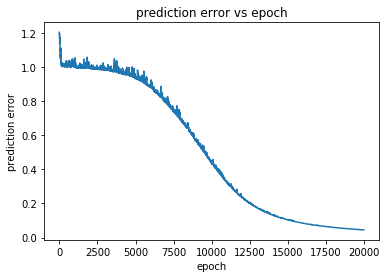

Final prediction
[0 0] 0.0536528579168
[0 1] 0.886585932446
[1 0] 0.89079511324
[1 1] 0.131571824539


In [6]:
# Call the fit function and train the network for a chosen number of epochs.
# Notice that, for less than 10000 epochs it doesn't converge correctly!!
nn.fit(data=X, labels=y, epochs=20000)

# Show the prediction results
print("Final prediction")
for s in X:
    print(s, nn.predict_single_data(s))